In [4]:
%matplotlib notebook
import os
import pandas as pd
import re
import numpy as np
import collections
import biosppy.signals
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasRegressor

In [5]:
DATA_TRAIN_PATH = 'blood-pressure-estimation-data/data_train'
DATA_TEST1_PATH = 'blood-pressure-estimation-data/data_test1_blank'
DATA_TEST2_PATH = 'blood-pressure-estimation-data/data_test2_blank'

In [6]:
class TRecord:
    def __init__(self, sample_id, sbp, dbp, ppg, ecg, uid):
        self.sample_id = sample_id
        self.sbp = sbp
        self.dbp = dbp
        self.ppg = ppg.copy()
        self.ecg = ecg.copy()
        self.uid = uid
        
        out_ecg = biosppy.signals.ecg.ecg(signal=np.array(ecg, dtype=float), sampling_rate=500., show=False)
        out_ppg = biosppy.signals.ecg.ecg(signal=np.array(ppg, dtype=float), sampling_rate=500., show=False)
            
        n = len(ecg)
        Fs = 500.
        k = np.arange(n)
        T = n / Fs
        frq = k / T # two sides frequency range
        #frq = frq[range(n//2)] # one side frequency range
        self.ecg_fft = abs(np.fft.fft(ecg))
        self.ecg_fft = np.log(self.ecg_fft[range(int(T), 250 * int(T), int(T))])
        
        '''
        fig0 = plt.figure().gca()
        fig0.plot(self.ecg)
        fig = plt.figure().gca()
        fig.plot(self.ecg_fft)
        '''
        self.hr = out_ecg['heart_rate']
        self.ppg_peaks = out_ppg['rpeaks']
        self.ecg_peaks = out_ecg['rpeaks']
    
    def __str__(self):
        return '\n{sample_id: %s \n sbp, dbp: %d, %d\n ppg: %s\n ecg: %s\n ppg_peaks: %s\n}' % (self.sample_id, self.sbp, self.dbp, str(self.ppg[:8]), str(self.ecg[:8]), str(self.ppg_peaks))
    
    def __repr__(self):
        return str(self)
        
def parse_name(name):
    r = re.search("subj(\\d+)log(\\d+)\\.csv", name)
    return (r.group(1), r.group(2))

def load_data(path, skip = 3000, is_train = False):
    filenames = os.listdir(path)
    data = {}
    for idx, file in enumerate(filenames):
        uid, saimpe_id = parse_name(file)
        ppg = []
        ecg = []
        with open(path + '/' + file, 'r') as f:
            for id, line in enumerate(f):
                vals = line[:-1].split(',')
                if id == 0:
                    sbp, dbp = float(vals[0]), float(vals[1])
                    continue
                ppg.append(float(vals[0]))
                ecg.append(float(vals[1]))
        
        if uid not in data:
            data[uid] = collections.defaultdict(list)
            
        try:
            rec = TRecord(saimpe_id, sbp, dbp, ppg[skip:], ecg[skip:], uid)
            data[uid]['bp' if sbp != 0 else 'nbp'].append(rec)
        except Exception:
            if is_train:
                pass
            else:
                raise
    return data
        
data_test = load_data(DATA_TEST1_PATH)
data_test2 = load_data(DATA_TEST2_PATH)
data_train = load_data(DATA_TRAIN_PATH, is_train=True)

In [7]:
def prepareRegressor(X, Y):
    clf = RandomForestRegressor(max_depth=30, random_state=42, n_estimators=100, n_jobs=-1, max_features=0.7)
    clf.fit(X, Y)
    return clf

def fill_list(x, cnt):
    return list(list(x) + [np.mean(x)] * (cnt - len(x)))

def feature_extractor(rec):
    mn = 11
    diff = np.abs(rec.ppg_peaks[:mn] - rec.ecg_peaks[:mn])
    #print(diff)
    #features = list(rec.ecg_fft) + list(rec.ecg[:5000]) + list(rec.ppg[:5000])
    #features =  list(rec.ecg_fft) + [np.max(rec.hr),np.min(rec.hr), np.average(rec.hr), np.min(diff), np.max(diff), np.average(diff)] + fill_list(diff[:mn], mn) + fill_list(rec.hr[:mn], mn)
    #features =  [np.max(rec.hr),np.min(rec.hr), np.average(rec.hr), np.min(diff), np.max(diff), np.average(diff)] + fill_list(diff[:mn], mn) + fill_list(rec.hr[:mn], mn)*/
    features = [np.max(rec.hr),np.min(rec.hr), np.average(rec.hr), np.min(diff), np.max(diff), np.average(diff)] + fill_list(diff[:mn], mn) + list(rec.ecg_fft[::10]) + fill_list(rec.hr[:mn], mn)
    #features = [np.max(rec.hr),np.min(rec.hr), np.average(rec.hr), np.min(diff), np.max(diff), np.average(diff)]
    return features

In [8]:
def get_user_stats(recs):
    hr = []
    sbp = []
    dbp = []
    dist_sbp_dbp = []
    diff = []
    mn = 7
    uid = 0
    for rec in recs:
        uid = rec.uid
        hr.append(np.average(rec.hr))
        sbp.append(rec.sbp)
        dbp.append(rec.dbp)
        dist_sbp_dbp.append(rec.sbp - rec.dbp)
        diff.append(np.average(np.abs(rec.ppg_peaks[:mn] - rec.ecg_peaks[:mn])))
        
    return [int(uid), np.average(hr), np.var(hr), np.max(hr), np.min(hr), np.average(sbp), np.var(sbp), np.max(sbp), np.min(sbp), np.average(dbp), np.var(dbp), np.max(dbp), np.min(dbp), np.average(diff), np.var(diff), np.max(diff), np.min(diff), np.average(dist_sbp_dbp), np.var(dist_sbp_dbp), np.max(dist_sbp_dbp), np.min(dist_sbp_dbp), len(recs)]



In [58]:
def prepare_train(seed):
    X_learn_sbp = []
    X_test_sbp = []
    Y_learn_sbp = []
    Y_test_sbp = []
    X_learn_dbp = []
    X_test_dbp = []
    Y_learn_dbp =[] 
    Y_test_dbp = []
    for uid in data_train:
        user_stats = get_user_stats(data_train[uid]['bp'])
        X_train = []
        Y_train_sbp = []
        Y_train_dbp = []
        for rec in data_train[uid]['bp']:
            X_train.append(user_stats + feature_extractor(rec))
            #X_train.append(user_stats)
            Y_train_sbp.append(rec.sbp)
            Y_train_dbp.append(rec.dbp)

        X_learn_sbp1, X_test_sbp1, Y_learn_sbp1, Y_test_sbp1  = train_test_split(X_train, Y_train_sbp, test_size=0.8, random_state=seed)
        X_learn_dbp1, X_test_dbp1, Y_learn_dbp1, Y_test_dbp1  = train_test_split(X_train, Y_train_dbp, test_size=0.8, random_state=seed)

        X_learn_sbp += X_learn_sbp1
        X_test_sbp += X_test_sbp1
        Y_learn_sbp += Y_learn_sbp1
        Y_test_sbp += Y_test_sbp1
        X_learn_dbp += X_learn_dbp1
        X_test_dbp += X_test_dbp1
        Y_learn_dbp += Y_learn_dbp1
        Y_test_dbp += Y_test_dbp1

    for uid in data_test:
        user_stats = get_user_stats(data_test[uid]['bp'])
        X_train = []
        Y_train_sbp = []
        Y_train_dbp = []
        for rec in data_test[uid]['bp']:
            X_train.append(user_stats + feature_extractor(rec))
            Y_train_sbp.append(rec.sbp)
            Y_train_dbp.append(rec.dbp)
        X_learn_sbp += X_train
        Y_learn_sbp += Y_train_sbp
        X_learn_dbp += X_train
        Y_learn_dbp += Y_train_dbp
    return X_learn_sbp, X_test_sbp, Y_learn_sbp, Y_test_sbp, X_learn_dbp, X_test_dbp, Y_learn_dbp, Y_test_dbp


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor


def sklearn_regressor():
    clf = ExtraTreesRegressor(max_depth=None, random_state=17, n_estimators=1200, n_jobs=-1, max_features=0.05)
    return clf

def sklearn_regressor_dbp():
    clf = ExtraTreesRegressor(max_depth=None, random_state=17, n_estimators=1200, n_jobs=-1, max_features=0.05)
    return clf

test_sbp = []
for i in range(10):
    X_learn_sbp, X_test_sbp, Y_learn_sbp, Y_test_sbp, X_learn_dbp, X_test_dbp, Y_learn_dbp, Y_test_dbp = prepare_train(i)
    regr_sbp = sklearn_regressor()
    regr_sbp.fit(X_learn_sbp, Y_learn_sbp)
    test_sbp.append(mean_squared_error(list(map(round, regr_sbp.predict(X_test_sbp))), Y_test_sbp))
print(np.average(test_sbp))
    
test_dbp = []
for i in range(10):
    X_learn_sbp, X_test_sbp, Y_learn_sbp, Y_test_sbp, X_learn_dbp, X_test_dbp, Y_learn_dbp, Y_test_dbp = prepare_train(i)
    regr_dbp = sklearn_regressor_dbp()
    regr_dbp.fit(X_learn_sbp, Y_learn_dbp)
    test_dbp.append(mean_squared_error(list(map(round, regr_dbp.predict(X_test_sbp))), Y_test_dbp))
print(np.average(test_dbp))
    

103.02248603351957
43.092318435754194


In [340]:
from keras.models import Sequential
from keras.layers import Dense, MaxPooling1D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit

def baseline_model():
    model = Sequential()
    model.add(Dense(11, input_dim = len(X_train[0]), kernel_initializer='normal', activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(7, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    adam_opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(loss='mean_squared_error', optimizer=adam_opt)
    return model

# def baseline_model():
#     model = Sequential()
#     model.add(Dense(13, input_dim = len(X_train[0]), kernel_initializer='normal', activation='relu'))
#     #model.add(MaxPooling1D(pool_size=5, strides=None))
#     #model.add(Dense(23, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(7, kernel_initializer='normal', activation='relu'))
#     #model.add(Dropout(0.5))
#     model.add(Dense(1, kernel_initializer='normal', activation='linear'))
#     adam_opt = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
#     model.compile(loss='mean_squared_error', optimizer=adam_opt)
#     #print(model.summary())
#     return model

seed = 7
np.random.seed(seed)
estimators = []
#estimators.append(('std', StandardScaler()))
estimator = KerasRegressor(build_fn=baseline_model, verbose=0)
estimators.append(('reg', estimator))
pipeline = Pipeline(estimators)
#result_keras = cross_val_score(pipeline, np.array(X_train), np.array(Y_train_sbp), scoring='neg_mean_squared_error', cv=ShuffleSplit(n_splits=2, test_size=0.2, random_state=0))
#print(abs(result_keras.mean()), result_keras.std())

history = estimator.fit(np.array(X_learn_sbp), Y_learn_sbp, epochs=1000, batch_size=5, validation_data=(np.array(X_test_sbp),Y_test_sbp))


<IPython.core.display.Javascript object>


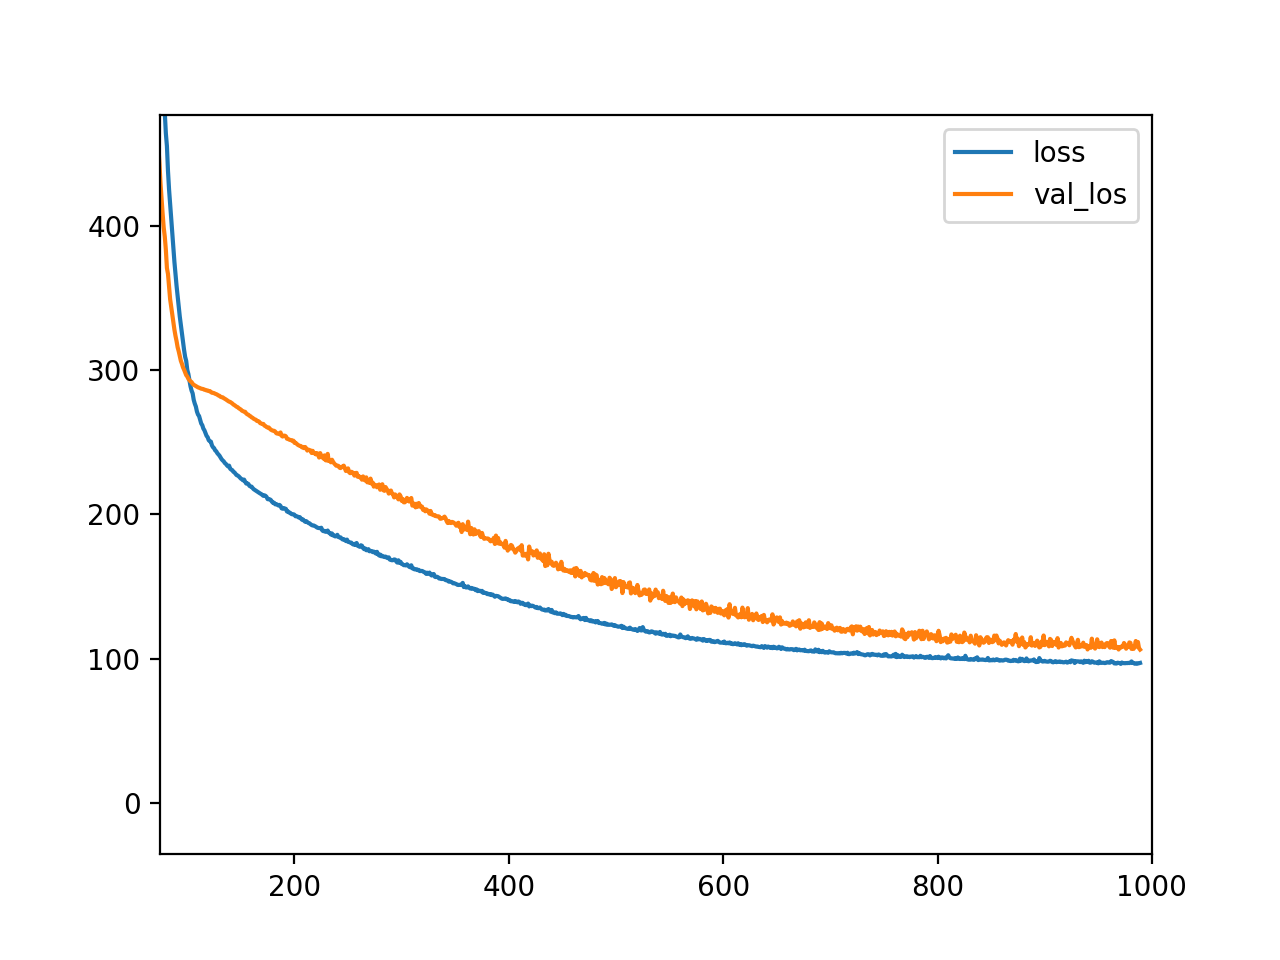

In [343]:
plt.clf()
plt.plot(history.history['loss'][10:], label='loss')
plt.plot(history.history['val_loss'][10:], label = 'val_los')
plt.legend()
plt.show()


In [104]:
history2 = estimator.fit(np.array(X_train), Y_train_sbp, validation_data=(np.array(X_test_sbp),Y_test_sbp), initial_epoch=1500, epochs=3000)

In [105]:
#plt.clf()
plt.plot(history2.history['loss'][20:])
plt.plot(history2.history['val_loss'][20:])
plt.show()


In [263]:
# def baseline_model_dbp():
#     model = Sequential()
#     model.add(Dense(11, input_dim = len(X_train[0]), kernel_initializer='normal', activation='relu'))
#     model.add(Dense(7, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(1, kernel_initializer='normal', activation='linear'))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model

def basebaseline_model_dbpline_model():
    model = Sequential()
    model.add(Dense(32, input_dim = len(X_train[0]), kernel_initializer='normal', activation='relu'))
    #model.add(MaxPooling1D(pool_size=5, strides=None))
    #model.add(Dropout(0.5))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    adam_opt = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(loss='mean_squared_error', optimizer=adam_opt)
    #print(model.summary())
    return model

seed = 7
np.random.seed(seed)
estimators = []
#estimators.append(('std', StandardScaler()))
estimator_dbp = KerasRegressor(build_fn=baseline_model_dbp, verbose=0)
estimators.append(('reg', estimator))
pipeline = Pipeline(estimators)
#result_keras = cross_val_score(pipeline, np.array(X_train), np.array(Y_train_dbp), scoring='neg_mean_squared_error', cv=ShuffleSplit(n_splits=2, test_size=0.2, random_state=0))
print(abs(result_keras.mean()), result_keras.std())

history = estimator_dbp.fit(np.array(X_train), Y_train_dbp, epochs=5000, batch_size=15, validation_data=(np.array(X_test_dbp),Y_test_dbp))


74.09295845934636 6.646077120853036


In [12]:
def printer(data, sbp_res, dbp_res):
    for rec in data[uid]['bp']:
        print('subj'+uid+'log'+rec.sample_id+'.csv', int(rec.sbp), int(rec.dbp), sep=',')
    for id, rec in enumerate(data[uid]['nbp']):
        print('subj'+uid+'log'+rec.sample_id+'.csv', int(round(sbp_res[id])), int(round(dbp_res[id])), sep=',')

In [68]:
for uid in data_test:
    X = []
    X_big = []
    Y_sbp = []
    Y_dbp = []
    
    user_stats = get_user_stats(data_test[uid]['bp'])
    for rec in data_test[uid]['bp']:
        X.append(user_stats+feature_extractor(rec))
        Y_sbp.append(rec.sbp)
        Y_dbp.append(rec.dbp)
    
    sbp_reg = sklearn_regressor()
    sbp_reg.fit(X, Y_sbp)
    dbp_reg = sklearn_regressor_dbp()
    dbp_reg.fit(X, Y_dbp)
    
    corr_tree_sbp = Y_sbp - regr_sbp.predict(X)
    corr_tree_dbp = Y_dbp - regr_dbp.predict(X)
    
    corr_sbp = Y_sbp - sbp_reg.predict(X)
    corr_dbp = Y_dbp - dbp_reg.predict(X)
    

    X_test = []
    for rec in data_test[uid]['nbp']:
        X_test.append(user_stats+feature_extractor(rec))
    
   
    sbp_pred = sbp_reg.predict(X_test)
    dbp_pred = dbp_reg.predict(X_test)
    sbp_pred2 = regr_sbp.predict(X_test)
    dbp_pred2 = regr_dbp.predict(X_test)
    
    
    sbp_pred += np.average(corr_sbp)
    dbp_pred += np.average(corr_sbp)
    sbp_pred2 += np.average(corr_tree_sbp)
    dbp_pred2 += np.average(corr_tree_dbp)
   
    
    printer(data_test, sbp_pred, dbp_pred)

subj15log939.csv,106,76
subj15log928.csv,106,62
subj15log941.csv,118,84
subj15log940.csv,100,71
subj15log938.csv,106,72
subj15log931.csv,106,73
subj15log932.csv,109,77
subj15log927.csv,104,75
subj15log930.csv,107,77
subj15log929.csv,110,92
subj15log933.csv,102,74
subj15log937.csv,106,66
subj15log936.csv,110,65
subj15log935.csv,116,86
subj15log934.csv,121,81
subj15log995.csv,107,74
subj15log968.csv,109,72
subj15log955.csv,107,73
subj15log989.csv,109,79
subj15log946.csv,108,71
subj15log978.csv,107,70
subj15log949.csv,108,78
subj15log966.csv,108,76
subj15log962.csv,110,74
subj15log947.csv,108,74
subj15log998.csv,109,76
subj15log952.csv,109,78
subj15log945.csv,109,79
subj15log963.csv,108,72
subj15log960.csv,108,75
subj15log986.csv,107,77
subj15log943.csv,109,74
subj15log987.csv,108,78
subj15log970.csv,108,73
subj15log999.csv,109,72
subj15log957.csv,108,73
subj15log961.csv,108,73
subj15log976.csv,108,72
subj15log953.csv,108,76
subj15log971.csv,109,79
subj15log951.csv,109,78
subj15log959.csv